c:\Users\ashto\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\ashto\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\ashto\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptr

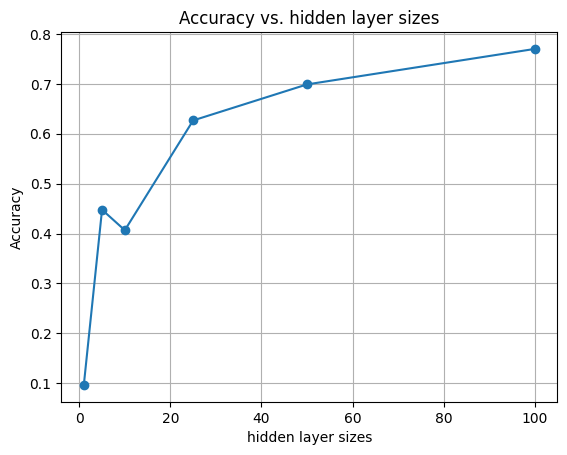

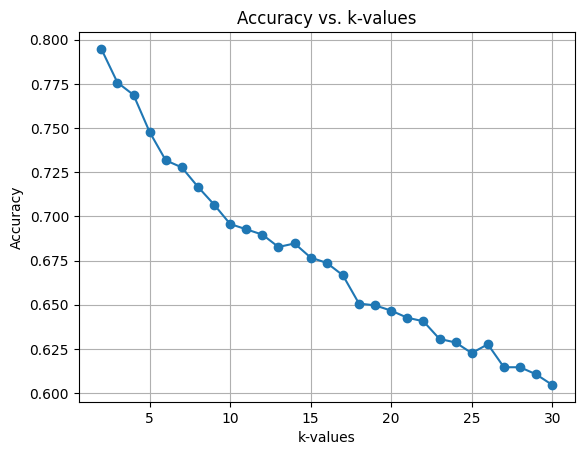

In [4]:
from python_speech_features import mfcc
from tempfile import TemporaryFile
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import pandas as pd
import numpy as np
import random
import pickle
import os

# sklearn imports
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

# compute the percentage of correct predictions
def check_labels(actual, predictions):
    num_correct = 0
    for i in range(len(predictions)):
        if ( actual[i] == predictions[i] ):
            num_correct += 1
    return num_correct / len(predictions)

# dump data from .wav files into a binary file for use in models
def load_data():
    directory = 'Data/genres_original'
    f = open("compressed_data.dat", "wb")

    i = 1
    for folder in os.listdir(directory):
        for file in os.listdir(directory + "/" + folder):
            try:
                (rate, signal) = wav.read(directory + "/" + folder + "/" + file)
                mfcc_feature = mfcc(signal, rate, winlen = 0.020, appendEnergy = False)
                covariance = np.cov(np.matrix.transpose(mfcc_feature))
                avg_matrix = mfcc_feature.mean(0)
                feature = (avg_matrix, covariance, i)
                pickle.dump(feature, f)
            except Exception as e:
                print("Error thrown: ", e)
        i += 1
    f.close()

# split is the percentage of data that will become train / test
# generate a summary binary file from the data directory
def split_data(split, trset, teset):
    dataset = []
    with open('compressed_data.dat','rb') as f:
        while True:
            try:
                dataset.append(pickle.load(f))
            except EOFError:
                f.close()
                break
        for x in range(len(dataset)):
            if random.random() < split: # if randomly generated value is < split param, add to train set
                trset.append(dataset[x])
            else: # >= split param, add to test set
                teset.append(dataset[x])

def main():
    # check if the compressed_data file has already been made
    if not os.path.exists('compressed_data.dat'):
        load_data() # if not, generate the data file
    
    trainingSet = []
    testSet = []
    split_data(1, trainingSet, testSet) # populates trainingSet and testSet (1 for other models)

    # populate X and y
    X = []
    y = []

    for data in trainingSet:
        X.append(data[0])
        y.append(data[2])

    # # Gaussian Naive Bayes 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=0)
    # gnb = GaussianNB()
    # y_pred = gnb.fit(X_train, y_train).predict(X_test)
    # accuracy = check_labels(y_test, y_pred)
    # print('predction accuracy (GNB): ', accuracy)

    hidden_layer_sizes = [1, 5, 10, 25, 50, 100]
    hidden_layer_accuracies = []

    for i in hidden_layer_sizes:
        # Neural Network Multi-Class Classifier 
        clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(i,), random_state=0)
        y_pred = clf.fit(X, y).predict(X_test)
        accuracy = check_labels(y_test, y_pred)
        hidden_layer_accuracies.append(accuracy)
        #print('predction accuracy (MLP): ', accuracy)

    # Plotting the graph
    plt.plot(hidden_layer_sizes, hidden_layer_accuracies, marker='o', linestyle='-')
    plt.title('Accuracy vs. hidden layer sizes')
    plt.xlabel('hidden layer sizes')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    # # SVM
    # clf = svm.SVC()
    # y_pred = clf.fit(X, y).predict(X_test)
    # accuracy = check_labels(y_test, y_pred)
    # print('predction accuracy (SVM): ', accuracy)

    knn_accuracies = []

    for i  in range(2, 31):
        # knn (sklearn)
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh.fit(X, y)
        accuracy = neigh.score(X, y, sample_weight=None)
        knn_accuracies.append(accuracy)
        # print('prediction accuracy with k = %d: ' % i, accuracy)

    # Create k-values corresponding to the indices of the array
    k_values = range(2, 31)

    # Plotting the graph
    plt.plot(k_values, knn_accuracies, marker='o', linestyle='-')
    plt.title('Accuracy vs. k-values')
    plt.xlabel('k-values')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()

    # print(knn_accuracies)

if __name__ == '__main__':
    main()
